In [1]:
import torch
import torch.nn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torchvision
import torch
from torch import nn, relu
from torchvision import datasets, transforms
from torch.distributions.kl import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from time import time
from model import LinearVAE, pPCA

In [2]:
class config:
    latent_dim = 200
    data_size = 1000
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(config.device)

def seed_torch(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)

cuda:0


In [3]:
start = time()
seed_torch(0)
latent_dim = config.latent_dim
data_size = config.data_size
device = config.device
mnist_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
]))
loader = mnist_data.data[:data_size].view(-1, 784) / 255.0
loader_numpy = loader.numpy()
loader = loader.to(device)

# Linear VAE
model = LinearVAE(784, latent_dim, 784, 1.0, True, mode='Analytic').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Probability PCA
pcaModel = pPCA(loader_numpy, latent_dim)
W_mle, sigma_mle, loglikelihood = pcaModel.get_result()

elbo_result = []
for i in range(1000000):
    elbo = model(loader)
    optimizer.zero_grad()
    elbo.backward()
    optimizer.step()
    if np.abs(-elbo.detach().cpu().numpy() - loglikelihood) < 1:
        print("End Epoch:{}".format(i))
        end = time()
        print("total time:{}s".format(end - start))
        break
    if i % 500 == 0:
        elbo_result.append(-elbo)
        print("Epoch:{},     \t exact loglikelihood:{},   \t ELBO:{}".format(i, loglikelihood, -elbo))

Epoch:0,     	 exact loglikelihood:961.9913221097786,   	 ELBO:-1793.98095703125
Epoch:500,     	 exact loglikelihood:961.9913221097786,   	 ELBO:-1078.3211669921875
Epoch:1000,     	 exact loglikelihood:961.9913221097786,   	 ELBO:-950.5664672851562
Epoch:1500,     	 exact loglikelihood:961.9913221097786,   	 ELBO:-839.693115234375
Epoch:2000,     	 exact loglikelihood:961.9913221097786,   	 ELBO:-736.1995849609375
Epoch:2500,     	 exact loglikelihood:961.9913221097786,   	 ELBO:-637.565185546875
Epoch:3000,     	 exact loglikelihood:961.9913221097786,   	 ELBO:-542.4310302734375
Epoch:3500,     	 exact loglikelihood:961.9913221097786,   	 ELBO:-449.9338073730469
Epoch:4000,     	 exact loglikelihood:961.9913221097786,   	 ELBO:-359.6425476074219
Epoch:4500,     	 exact loglikelihood:961.9913221097786,   	 ELBO:-271.1060485839844
Epoch:5000,     	 exact loglikelihood:961.9913221097786,   	 ELBO:-184.28289794921875
Epoch:5500,     	 exact loglikelihood:961.9913221097786,   	 ELBO:-99.

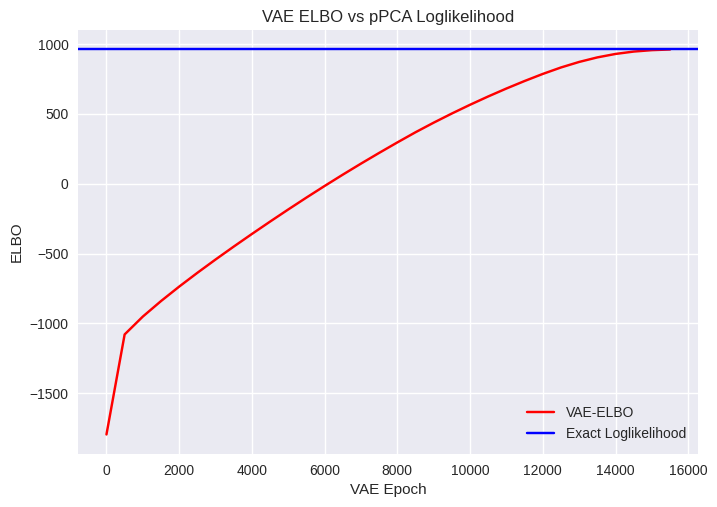

In [7]:
elbo_numpy_result = [item.detach().cpu().numpy() for item in elbo_result]
plt.plot(500*np.arange(len(elbo_numpy_result)),elbo_numpy_result,label="VAE-ELBO",color='red')
plt.axhline(y=loglikelihood,label="Exact Loglikelihood",color='blue')
plt.xlabel("VAE Epoch")
plt.ylabel("ELBO")
plt.legend(loc = "best")
plt.title("VAE ELBO vs pPCA Loglikelihood")
plt.savefig("VAE_ELBO_vs_pPCA_Loglikelihood.jpg",dpi=500)
plt.style.use('seaborn')
plt.show()

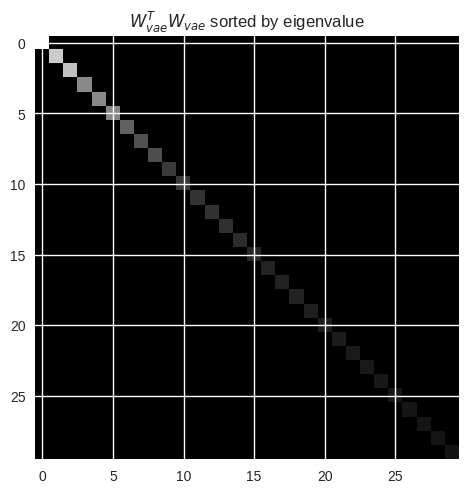

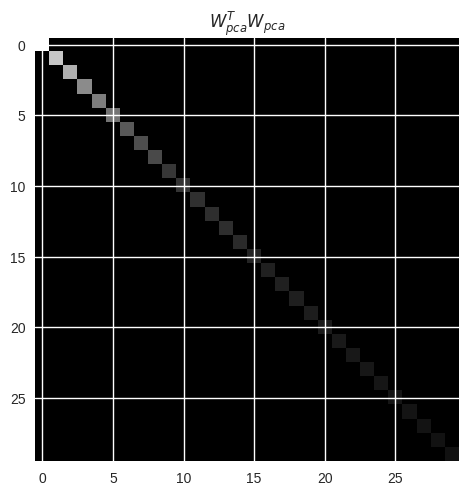

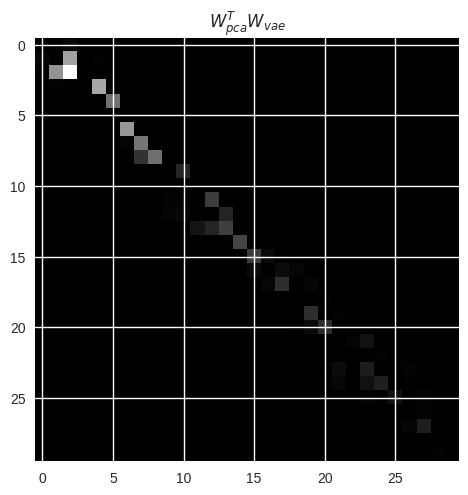

In [8]:
W = model.W.detach().cpu().numpy()#200,784
W_vae = W.T  #784,200
W_pca = W_mle

WTW_vae = W_vae.T@W_vae
WTW_pca = W_pca.T@W_pca

diag = np.diag(WTW_vae)
sort_idx = np.argsort(-diag)

W_vae_sorted=(W_vae.T[sort_idx]).T
WTW_vae_sorted = W_vae_sorted.T@W_vae_sorted

plt.figure()
plt.imshow(WTW_vae_sorted[:30,:30], cmap='gray', vmin=0.0)
plt.title(r'$W_{vae}^T W_{vae}$ sorted by eigenvalue')
plt.savefig("WTWVAE.jpg",dpi=500)

plt.figure()
plt.imshow(WTW_pca[:30,:30], cmap='gray', vmin=0.0)
plt.title(r'$W_{pca}^T W_{pca}$')
plt.savefig("WTWPCA.jpg",dpi=500)

W_pca_T_W_vae = W_pca.T@W_vae_sorted
plt.figure()
plt.imshow(W_pca_T_W_vae[:30,:30], cmap='gray', vmin=0.0)
plt.title(r'$W_{pca}^T W_{vae}$')
plt.savefig("WVAETWPCA.jpg",dpi=500)